# Convolutional Neural Network - OCR
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
The previous notebook showed that a simple linear model had about 91% classification accuracy for recognizing hand-written digits in the MNIST data-set.

In this notebook we will implement a simple **Convolutional Neural Network** in $TensorFlow$ which has a classification accuracy of about 99%, or more.

Convolutional Networks work by moving small filters across the input image. This means the filters are re-used for recognizing patterns throughout the entire input image, making the Convolutional Networks much more powerful than Fully-Connected networks with the same number of variables. A Convolutional Network is also faster to train.

## Flowchart
The following chart shows roughly how the data flows in the Convolutional Neural Network that is implemented below.

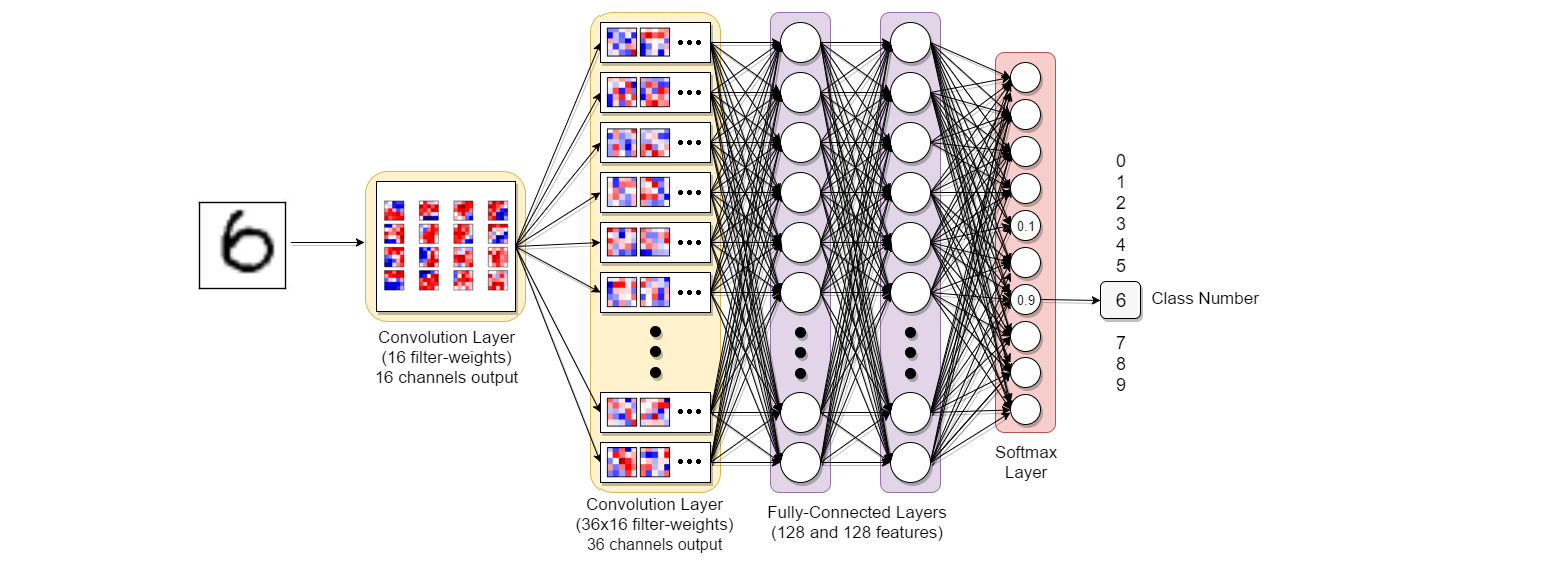

In [1]:
from IPython.display import Image
Image('images/02_flowchart.png')

The input image is processed in the first convolutional layer using the filter-weights. This results in 16 new images, one for each filter in the convolutional layer. The resulting images are also down-sampled from 28x28 to 14x14 pixels.

These 16 smaller images are then processed in the second convolutional layer. There are 36 output channels in this output layer, so there are a total of 16 x 36 = 576 filters in the second convolutional layer, because we need filter-weights for each of these 16 channels, and we need filter-weights for each output channel of this layer. The resulting images are down-sampled again to 7x7 pixels.

The output of the second convolutional layer is 36 images of 7x7 pixels each. These are then flattened to a single vector of length 7 x 7 x 36 = 1764, which is used as the input to a fully-connected layer with 128 neurons. This feeds into another fully-connected layer with 10 neurons, one for each of the classes, which is used to determine the class of the image (the number depicted in the image), as in the previous notebook.

The convolutional filters are initially chosen at random, so the classification is done randomly. The error between the predicted and true class of the input image is measured again as cross-entropy. The optimizer then automatically propagates this error back through the Convolutional Network using the chain-rule of differentiation and updates the filter-weights so as to improve the classification error. This is done iteratively thousands of times until the classification error is sufficiently low.

These particular filter-weights and intermediate images are the results of one optimization run and may look different if you re-run this notebook.

Note that the computation in $TensorFlow$ is actually done on a batch of images instead of a single image, which makes the computation more efficient. 

## Convolutional Layer
The following chart shows the basic idea of processing an image in the first convolutional layer. The input image depicts the number 7 and four copies of the image are shown here, so we can see more clearly how the filter is being moved to different positions of the image. For each position of the filter, the dot-product is being calculated between the filter and the image pixels under the filter, which results in a single pixel in the output image. So moving the filter across the entire input image results in a new image being generated.

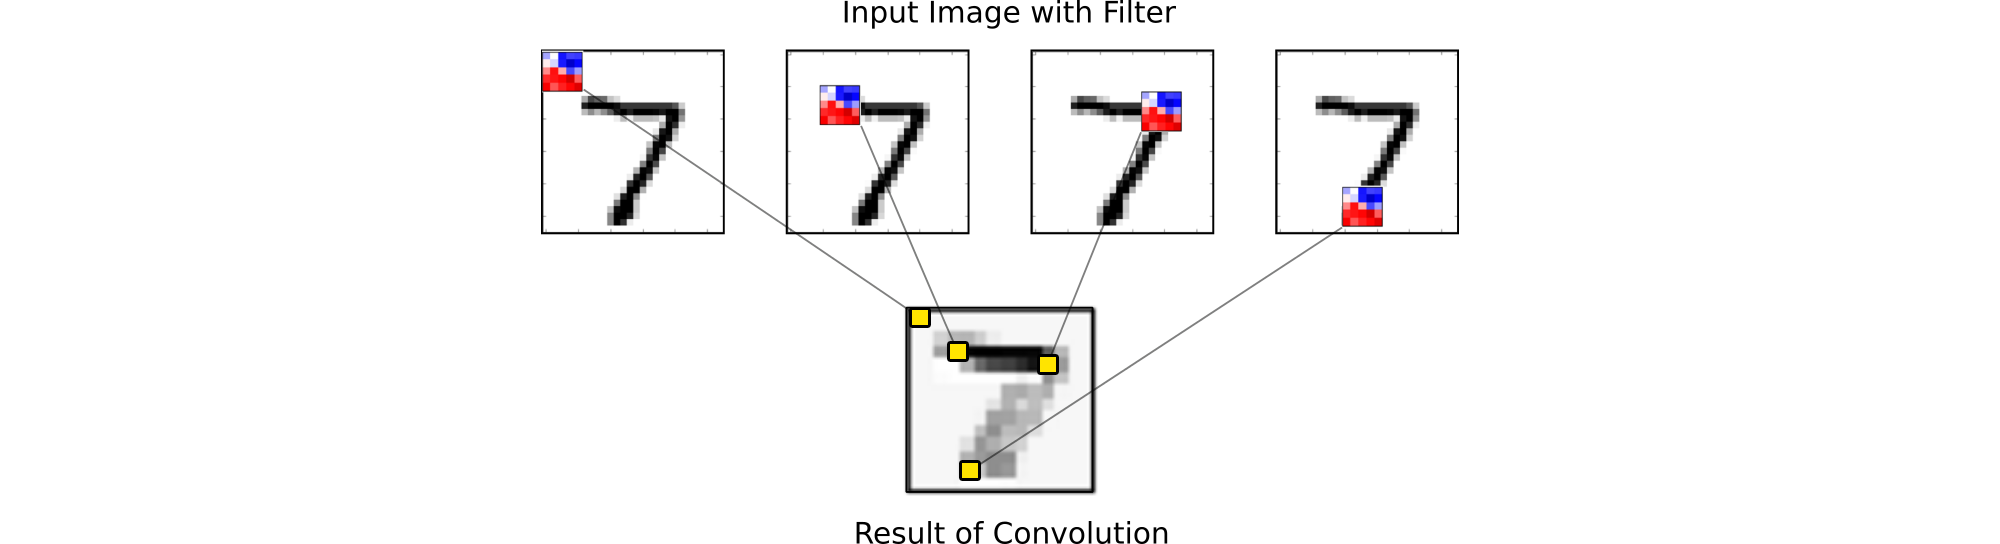

In [2]:
Image('images/02_convolution.png')

The red filter-weights means that the filter has a positive reaction to black pixels in the input image, while blue pixels means the filter has a negative reaction to black pixels.

In this case it appears that **the filter recognizes the horizontal line** of the 7-digit, as can be seen from its stronger reaction to that line in the output image.

The step-size for moving the filter across the input is called the stride. There is a stride for moving the filter horizontally (x-axis) and another stride for moving vertically (y-axis).

In the source-code below, the stride is set to 1 in both directions, which means the filter starts in the upper left corner of the input image and is being moved 1 pixel to the right in each step. When the filter reaches the end of the image to the right, then the filter is moved back to the left side and 1 pixel down the image. This continues until the filter has reached the lower right corner of the input image and the entire output image has been generated.

When the filter reaches the end of the right-side as well as the bottom of the input image, then it can be padded with zeroes (white pixels). This causes the output image to be of the exact same dimension as the input image.

Furthermore, the output of the convolution may be passed through a so-called Rectified Linear Unit (ReLU), which merely ensures that the output is positive because negative values are set to zero. The output may also be down-sampled by so-called max-pooling, which considers small windows of 2x2 pixels and only keeps the largest of those pixels. This halves the resolution of the input image e.g. from 28x28 to 14x14 pixels.

## Imports
As in the previous notebook, helper functions are in [util.py](util.py).

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta

from util import Util
u = Util()

tf.__version__

'1.10.0'

## Configuration of Neural Network

In [3]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Data Load
We load the same dataset as the previous notebook. 

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [5]:
print("Size of")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


As we did before, we need the number corrisponding to the class-labels, that are One-Hot encoded

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

### Data Dimensions

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images
Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [9]:
def plot_images(images, cls_true, cls_pred=None): 
    u.plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred, img_size=img_size, img_shape=img_shape)

### Plot a few images to see if data is correct

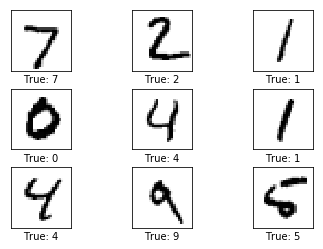

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph
Aside from the convolutional part, the structure of the $TensorFlow$ graph is the same as the previous notebook, consisting of the following parts:
- Placeholder variables used for inputting data to the graph.
- Variables that are going to be optimized so as to make the convolutional network perform better.
- The mathematical formulas for the convolutional network.
- A cost measure that can be used to guide the optimization of the variables.
- An optimization method which updates the variables.

### Helper-functions for creating new variables
Functions for creating new $TensorFlow$ variables in the given shape and initializing them with random values. Note that the initialization is not actually done at this point, it is merely being defined in the $TensorFlow$ graph. In the previous notebook we used zeros instead of random values.

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer
This function creates a new convolutional layer in the computational graph for $TensorFlow$. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.

It is assumed that the input is a 4-dim *tensor* with the following dimensions:
- Image number.
- Y-axis of each image.
- X-axis of each image.
- Channels of each image.

Note that the input channels may either be colour-channels, or it may be filter-channels if the input is produced from a previous convolutional layer.

The output is another 4-dim *tensor* with the following dimensions:
- Image number, same as input.
- Y-axis of each image. If 2x2 pooling is used, then the height and width of the input images is divided by 2.
- X-axis of each image. As above.
- Channels produced by the convolutional filters.

In [12]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### Helper-function for flattening a layer
A convolutional layer produces an output tensor with 4 dimensions. We will add fully-connected layers after the convolution layers, so we need to reduce the 4-dim tensor to 2-dim which can be used as input to the fully-connected layer.

In [13]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer
This function creates a new fully-connected layer in the computational graph for $TensorFlow$. Nothing is actually calculated here, we are just adding the mathematical formulas to the TensorFlow graph.
It is assumed that the input is a 2-dim tensor of shape [num_images, num_inputs]. The output is a 2-dim tensor of shape [num_images, num_outputs].

In [14]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### Placeholder variables
Placeholder variables serve as the input to the $TensorFlow$ computational graph that we may change each time we execute the graph (feeding).

First we define the placeholder variable for the input images. This allows us to change the images that are input to the $TensorFlow$ graph. This is a so-called tensor, which just means that it is a multi-dimensional vector or matrix. The data-type is set to float32 and the shape is set to [None, img_size_flat], where None means that the tensor may hold an arbitrary number of images with each image being a vector of length img_size_flat.

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [16]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [17]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [18]:
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Convolutional Layer 1
We'll now create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [19]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

The shape of the tensor that will be output by the convolutional layer is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.

In [20]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2
We create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [21]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

The shape is (?, 7, 7, 36).

In [22]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer
As said before, the convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [23]:
layer_flat, num_features = flatten_layer(layer_conv2)

The tensors now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each.

In [24]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [25]:
num_features

1764

### Fully-Connected Layer 1
This code adds a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [26]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

The output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128.

In [27]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2
This adds another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [28]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [29]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Predicted Class
The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [30]:
y_pred = tf.nn.softmax(layer_fc2)
# the class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost-function to be optimized
As in the previous notebook, we use the built-in function for calculating *cross-entropy*. Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [33]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method
Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the **AdamOptimizer** which is an advanced form of Gradient Descent.

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures
We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [35]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [36]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

Once the $TensorFlow$ graph has been created, we have to create a $TensorFlow$ session which is used to execute the graph. The variables for weights and biases must also be initialized before we start optimizing them.

In [37]:
session = tf.Session()
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Helper-function to perform optimization iterations
There are 55000 images in the training-set. It takes a long time to calculate the gradient of the model using all these images. We therefore only use a small batch of images in each iteration of the optimizer. This is also done to avoid running out of memory. 

In [38]:
train_batch_size = 64

This function performs a number of optimization iterations to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then $TensorFlow$ executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [39]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    # Start-time used for printing time-usage below.
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        # Get a batch of training examples.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        # Put the batch into a dict with the proper names
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)
        # Print status every 100 iterations.
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))
    # Update the total number of iterations performed.
    total_iterations += num_iterations
    
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function for showing the performance
This function prints the classification accuracy on the test-set. It will also print example errors and confusion matrix if asked. 

It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.
Note that this function can use a lot of computer memory, so it has a parameter to specify a batch size.

In [40]:
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False): 
    u.print_test_accuracy(session=session, data=data, x=x, y_true=y_true, y_pred_cls=y_pred_cls, num_classes=num_classes, 
                          show_example_errors=show_example_errors, show_confusion_matrix=show_confusion_matrix)

## Performance before and after learning
As we did with the previous notebook, we'll calculate the accuracy on the test-set at various points, increasing the iterations of optimization in between. At this point it is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [41]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (978 / 10000)


### Performance after 1 optimization iteration
The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low, unlike the previous notebook, where it jumps to 40%.

In [42]:
optimize(num_iterations=1)
print_test_accuracy()

Optimization Iteration:      1, Training Accuracy:   6.2%
Time usage: 0:00:00
Accuracy on Test-Set: 10.0% (997 / 10000)


### Performance after 100 optimization iterations
After 100 optimization iterations the model has significantly improved its classification accuracy.

Time usage: 0:00:07
Accuracy on Test-Set: 74.0% (7401 / 10000)
Example errors:


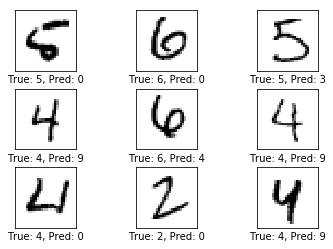

In [43]:
# We already performed 1 iteration above.
optimize(num_iterations=99)
print_test_accuracy(show_example_errors=True)

### Performance after 1000 optimization iterations
After 1000 optimization iterations the model has greatly increased its accuracy on the test-set to more than 90%.

Optimization Iteration:    101, Training Accuracy:  73.4%
Optimization Iteration:    201, Training Accuracy:  78.1%
Optimization Iteration:    301, Training Accuracy:  71.9%
Optimization Iteration:    401, Training Accuracy:  82.8%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  92.2%
Optimization Iteration:    901, Training Accuracy:  85.9%
Time usage: 0:01:26
Accuracy on Test-Set: 92.7% (9272 / 10000)
Example errors:


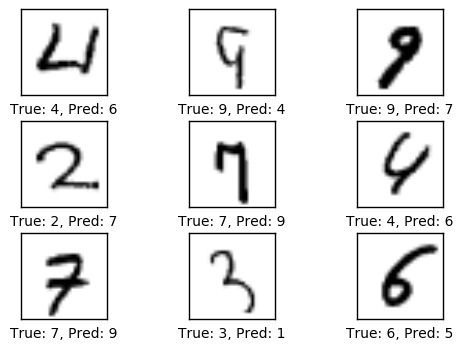

In [43]:
# We performed 100 iterations above.
optimize(num_iterations=900)
print_test_accuracy(show_example_errors=True)

### Performance after 10000 optimization iterations
After 10000 optimization iterations the model has a classification accuracy on the test-set of about 99%.

In [44]:
optimize(num_iterations=9000)

Optimization Iteration:    101, Training Accuracy:  78.1%
Optimization Iteration:    201, Training Accuracy:  78.1%
Optimization Iteration:    301, Training Accuracy:  81.2%
Optimization Iteration:    401, Training Accuracy:  90.6%
Optimization Iteration:    501, Training Accuracy:  95.3%
Optimization Iteration:    601, Training Accuracy:  90.6%
Optimization Iteration:    701, Training Accuracy:  92.2%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  95.3%
Optimization Iteration:   1001, Training Accuracy:  92.2%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  90.6%
Optimization Iteration:   1301, Training Accuracy:  96.9%
Optimization Iteration:   1401, Training Accuracy:  96.9%
Optimization Iteration:   1501, Training Accuracy: 100.0%
Optimization Iteration:   1601, Training Accuracy:  96.9%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization I

Accuracy on Test-Set: 98.5% (9850 / 10000)
Example errors:


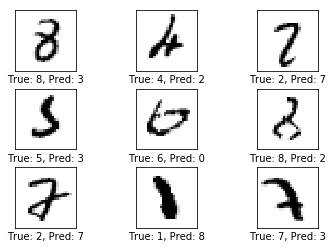

Confusion Matrix:
[[ 970    0    1    0    0    3    2    1    3    0]
 [   0 1123    5    0    0    1    1    1    4    0]
 [   0    1 1025    2    0    0    0    3    1    0]
 [   0    0    0 1006    0    1    0    0    3    0]
 [   0    0    2    0  971    0    1    2    2    4]
 [   1    0    0   12    0  875    1    1    1    1]
 [   4    2    0    1    1    5  944    0    1    0]
 [   0    1    9    5    0    0    0 1011    1    1]
 [   2    0    5   11    1    2    0    3  948    2]
 [   3    3    1    8    5    3    0    6    3  977]]


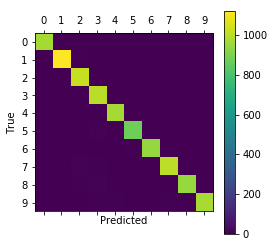

In [45]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Visualization of Weights and Layers
In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

### Helper-function for plotting convolutional weights

In [46]:
def plot_conv_weights(weights, input_channel=0):
    u.plot_conv_weights(session=session, weights=weights, input_channel=input_channel)

### Helper-function for plotting the output of a convolutional layer

In [47]:
def plot_conv_layer(layer, image):
    u.plot_conv_layer(session=session, x=x, layer=layer, image=image)

### Helper-function for plotting an image with nearest interpolation.

In [48]:
def plot_image(image):
    u.plot_image(image=image, img_shape=img_shape)

### Input image
We'll now plot an image from the test set to see how it changes between the varous layers.

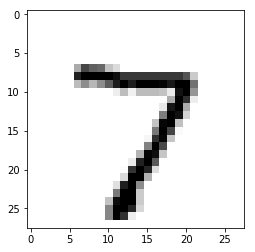

In [49]:
image1 = data.test.images[0]
plot_image(image1)

### Convolution layer 1
This is the first randomly generated convolution layer.

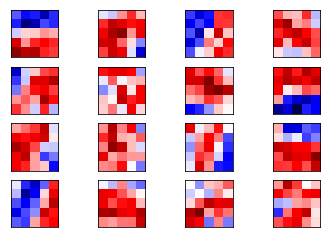

In [50]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14 x 14 pixels which is half the resolution of the original input image.

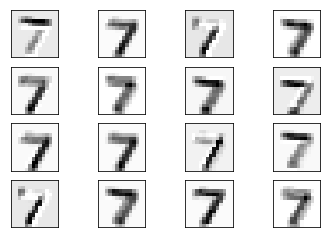

In [51]:
plot_conv_layer(layer=layer_conv1, image=image1)

### Convolution Layer 2
Now we plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

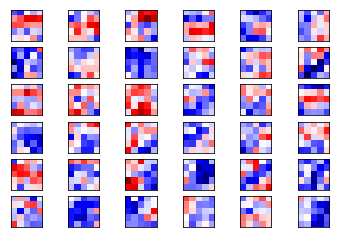

In [52]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

It can be difficult to understand and keep track of how these filters are applied because of the high dimensionality.

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

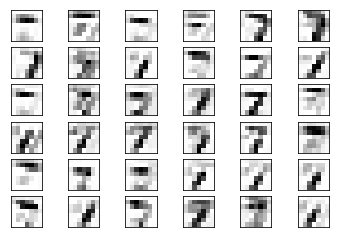

In [53]:
plot_conv_layer(layer=layer_conv2, image=image1)

From these images, it looks like the second convolutional layer might detect lines and patterns in the input images, which are less sensitive to local variations in the original input images.

These images are then flattened and input to the fully-connected layer.

We are now done using $TensorFlow$, so we close the session to release its resources.

In [54]:
session.close()

## Performance
Making a comparison with the previous notebook, we notice that the CNN takes about 15 minutes to complete the 10000 optimizations, while the simple linear NN takes a few seconds. This is because of the number of convolutional layers that must be trained.

On the other hand, we see an improvement in accuracy, going from the 92% of the linear NN to the 98% of the CNN.

## Conclusion
We have seen that a Convolutional Neural Network works much better at recognizing hand-written digits than the simple linear model after the same number of iterations. 

However, the Convolutional Network is also much more complicated to implement, and it is not obvious from looking at the filter-weights why it works and why it sometimes fails. We would also like to train the weights for the convolutional network instead of using random ones, in order to extract useful features.

There is an easier, higher level, way to program Convolutional Neural Networks with $TensorFlow$ using **PrettyTensor**, but it hides what's going on behind. 

In the next notebook we will show a faster way to implement the same kind of CNN, also using the **Saver** included in $TensorFlow$, but this time to classify images from the CIFAR dataset instead of digits.